# Welcome to Bellatrex

After making sure that the needed packages are installed, we can dive into the `tutorial.py` code.

## Step 1: import libraries and set parameters

Import the required libraries and set the parameters for the grid search, data folder paths, and other configuration variables

In [1]:
import numpy as np
import os
os.environ["OMP_NUM_THREADS"] = "1" # avoids memory leak UserWarning caused by KMeans
import pandas as pd

# reduce MAX_TEST_SIZE for quick code testing
MAX_TEST_SIZE = 999 # default size is len(X_test), limited to max 100 samples. Set a small number for quicker testing on fewer instances

p_grid = {
    "n_trees": [0.6, 0.8, 1.0],
    "n_dims": [2, 5, None],
    "n_clusters": [1, 2, 3]
    }

##########################################################################
root_folder = os.getcwd()

data_folder = os.path.join(root_folder, "example-data")

''' choose appropriate learning task wth SETUP parameter '''
# for this tutorial you cna choose between "bin""," "surv", or "mtr" 
SETUP = "mtr" 

VERBOSE = 2
MAX_TEST_SIZE = 3

PLOT_GUI = False
'''  levels of verbosity in this script:
    - >= 1.0: print best params, their achieved fidelity,
              and the scoring method used to compute such performance
    - >= 2.0: print final tree idx cluster sizes
              and store txt files with the extracted rule-paths
    - >= 3.0: plot representation of the extracted trees (two plots)
    - >= 4.0: plot trees with GUI (if PLOT_GUI == True)
    - >= 4.0: plot trees without GUI (if PLOT_GUI == False)
    - >= 5.0: print params and performance during GridSearch
'''

# running different RFs or different performance measures according to the 
# prediction scenarios. So far we have implemented the following 5 cases:
binary_key_list = ["bin", "binary"]
survival_key_list = ["surv", "survival"]
multi_label_key_list = ["multi", "multi-l", "multi-label", "mtc"]
regression_key_list = ["regression", "regress", "regr"]
mt_regression_key_list = ["multi-target", "multi-t", "mtr"]

## Step 2: Load and preprocess Data

Load training and testing data from the `.csv` files, split them into features (X) and targets (y), and preprocess the data by formatting the target variables according to the prediction scenarios. Instantiate the appropriate `RandomForest` model.

In [2]:
from code_scripts.utilities import output_X_y

df_train = pd.read_csv(os.path.join(data_folder, SETUP + '_tutorial_train.csv'))
df_test = pd.read_csv(os.path.join(data_folder, SETUP + '_tutorial_test.csv'))

X_train, y_train = output_X_y(df_train, SETUP)
X_test, y_test = output_X_y(df_test, SETUP)

X_train = X_train.drop("Unnamed: 0", axis=1, errors="ignore", inplace=False)
X_test = X_test.drop("Unnamed: 0", axis=1, errors="ignore", inplace=False)

assert X_train.isnull().sum().sum() < 1 #make sure there are no null values
assert X_test.isnull().sum().sum() < 1 #make sure there are no null values

# for quick testing, set a small MAX_TEST_SIZE
X_test = X_test[:MAX_TEST_SIZE]
y_test = y_test[:MAX_TEST_SIZE]

orig_n_labels = y_test.shape[1] #meaningful only in multi-output

In [3]:
from code_scripts.utilities import format_targets

from sksurv.ensemble import RandomSurvivalForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

y_train, y_test = format_targets(y_train, y_test, SETUP, VERBOSE)

### instantiate original R(S)F estimator
if SETUP.lower() in survival_key_list:
    clf = RandomSurvivalForest(n_estimators=100, min_samples_split=10,
                              random_state=0)

elif SETUP.lower() in binary_key_list + multi_label_key_list:
    clf = RandomForestClassifier(n_estimators=100, min_samples_split=5,
                                random_state=0)
    
elif SETUP.lower() in regression_key_list + mt_regression_key_list:
    clf = RandomForestRegressor(n_estimators=100, min_samples_split=5,
                               random_state=0)

clf.fit(X_train, y_train)


orig. n* labels: 3
new n* labels: 1


C:\Users\u0135479\AppData\Local\Temp\ipykernel_11980\2197041739.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


RandomForestRegressor(min_samples_split=5, random_state=0)

## Step 3: Instantiate and fit the Model

Once the Random Forest is instantiated, the `fit` method in Bellatrex trains the Random Forest and set the parameters for Bellatrex.


In [4]:
from code_scripts.LocalMethod_class import Bellatrex

# fit RF here. The hyperparameters are given      
Bellatrex_fitted = Bellatrex(clf, SETUP,
                            p_grid=p_grid,
                            proj_method="PCA",
                            dissim_method="rules",
                            feature_represent="weighted",
                            n_jobs=1,
                            verbose=1,
                            colormap= 'RdYlBu_r',
                            plot_GUI=PLOT_GUI).fit(X_train, y_train)


Model is already fitted, building explanation.


Storing train data predictions, useful for plotting the output distribution and compare the test data prediction to it.
NOTE that for this example we are storing the .npy array with a generic name of the form SETUP + '_tutorial_y_train_preds.npy'
You might want to name according to the dataset and fold under consideration

In [5]:
from code_scripts.utilities import predict_helper
y_train_pred = predict_helper(Bellatrex_fitted.clf, X_train)
np.save(os.path.join(os.path.join(data_folder, SETUP + '_tutorial_y_train_preds.npy')), y_train_pred)


## Step 4: Make predictions, output explanations

Loop through the test set, make predictions using the Bellatrex local method, and store the results.

In [6]:
from code_scripts.utilities import score_method
# store, for every sample in the test set, the predictions from BELLATREX and the original R(S)F for comparison
N = min(X_test.shape[0], MAX_TEST_SIZE)        

# store final Bellatrex predictions here.
# y_pred will be a (n_samples, n_outputs_) ndarray, or (n_samples,) for single output
y_pred = np.empty((0, 0))
# we harmonise everything with the predict_helper and concatenate_helper functions                
from code_scripts.utilities import predict_helper, concatenate_helper
y_ens_pred = predict_helper(clf, X_test)

j = 0 # fold index. No cross-validation in this example file. Setting j = 0

for i in range(N): #for every sample in the test set: call the .explain method. 
    # The hyperparameters were given in the .fit. and are actively used and tuned for every instance
    '''
    the .explain outputs:
        - the local prediction 
        - information about the Bellatrex instance: optimal parameters,
                    final extracted trees/rules, their weight in the prediction, etc... 
    '''
    FILE_OUT = None
    # uncomment the next 3 lines to store the explanations as .txt files :
    FILENAME_OUT = "Rules_"+str(SETUP)+"_f"+str(j)+'_id'+str(i)+'.txt'
    FILE_OUT = os.path.join(root_folder, 'example-explanations', FILENAME_OUT)

    y_local_pred, sample_info = Bellatrex_fitted.explain(X_test, i, out_file=FILE_OUT) # tuning is also done within the .explain method
    
    # append all test sample predictions in y_pred
    y_pred = concatenate_helper(y_pred, y_local_pred, axis=0)


best params: {'n_clusters': 3, 'n_dims': 5, 'n_trees': 100}
Achieved fidelity: 1.0000
(Tuned according to L2)
Bellatrex prediction: 0.001
Black box prediction: 0.001
######################################################
best params: {'n_clusters': 2, 'n_dims': 2, 'n_trees': 80}
Achieved fidelity: 1.0000
(Tuned according to L2)
Bellatrex prediction: 0.002
Black box prediction: 0.002
######################################################
best params: {'n_clusters': 3, 'n_dims': 2, 'n_trees': 100}
Achieved fidelity: 0.9998
(Tuned according to L2)
Bellatrex prediction: 0.000
Black box prediction: 0.001
######################################################


Predictions form Bellatrex and the corresponding black-box model are stored. here we compare the performance on (a small subset of) the test set.

In [10]:
#quick testing with few samples (less than 100)
y_test = y_test[:N]
y_ens_pred = y_ens_pred[:N]

for key, value in score_method(y_test, y_pred, SETUP).items():
    print(f'Bellatrex performance: {key}: {value:.4f}')

for key, value in score_method(y_test, y_ens_pred, SETUP).items():
    print(f'Black-box performance: {key}: {value:.4f}')

Bellatrex performance: MAE: 0.0074
Black-box performance: MAE: 0.0076


## Enhanced explanations

(0.0, 1.0)

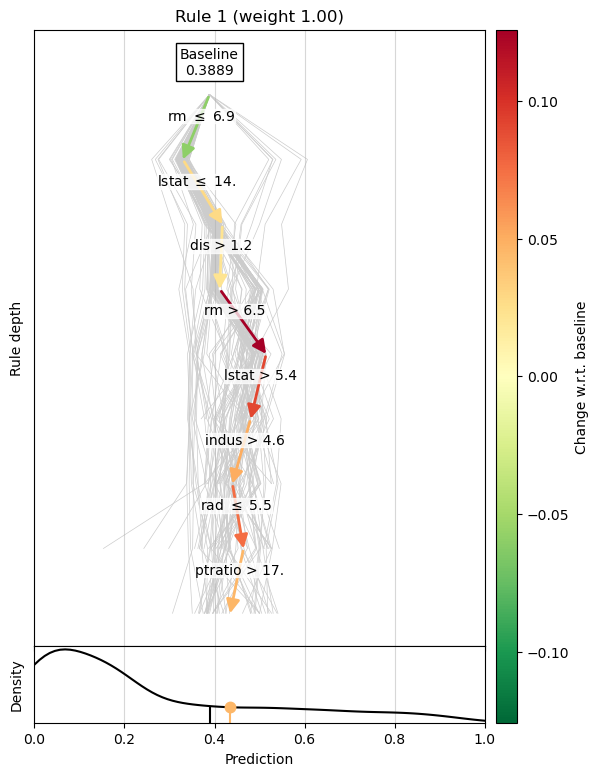

In [11]:
from visualisation import read_rules, plot_rules

rules, preds, baselines, weights, other_preds = read_rules(
    file       = "example-explanations/Rules_boston_housing_f0_id0.txt",
    file_extra = "example-explanations/Rules_boston_housing_f0_id0-extra.txt"
)
preds_distr = np.load("example-data/bin_tutorial_y_train_preds.npy")
axs = plot_rules(rules, preds, baselines, weights, 
            max_rulelen=None, other_preds=other_preds, preds_distr=preds_distr,
)
axs[0].set_xlim([0,1])
# plt.savefig("visualisation.pdf")
